In [1]:
import pandas as pd
import matplotlib as mpl
import numpy as np
import matplotlib.pyplot as plt
import wmfdata as wmf
from wmfdata.charting import comma_fmt, pct_fmt, M_fmt
from wmfdata.utils import pct_str

You can find the source for `wmfdata` at https://github.com/neilpquinn/wmfdata


In [2]:
%matplotlib inline
wmf.charting.set_mpl_style()

In [3]:
m = pd.read_csv(
    "../metrics/metrics.tsv", 
    sep="\t",
    parse_dates=["month"]
).set_index("month")

# Wiki segments

In [4]:
def wiki_segment(w):
    next_10_wps = (
        "eswiki", "dewiki", "jawiki", "frwiki", "ruwiki",
        "itwiki", "zhwiki", "ptwiki", "plwiki", "nlwiki"
    )
    
    if w == "enwiki":
        return "English Wikipedia"
    elif w in next_10_wps:
        return "'next 10' Wikipedias"
    elif w == "commonswiki":
        return "Commons"
    elif w == "wikidatawiki":
        return "Wikidata"
    else:
        return "other projects"

# Global editors dataset

In [34]:
global_eds_r = wmf.mariadb.run("""
select 
    month,
    age_group,
    count(*) as eds,
    sum(content_edits >= 5) as active_eds,
    sum(content_edits >= 100) as very_active_eds
from (
    select
        month,
        -- Convert from BINARY to CHAR so that case-insentive regexes work
        convert(user_name using utf8) as name,
        sum(edits) as edits,
        sum(content_edits) as content_edits,
        case
            when extract(year_month from min(user_registration)) = 
                extract(year_month from month)
            then "new"
            when extract(year_month from min(user_registration)) =
                extract(year_month from date_sub(month, interval 1 month))
            then "second-month"
            else "existing"
        end as age_group,
        max(bot_flag) as bot_flag
    from staging.editor_month
    where 
        month >= "{start}" and
        local_user_id != 0
    group by month, name
) global_edits
where
    -- A user is a bot if they have a matching name or have the bot flag on *any* wiki
    -- See https://meta.wikimedia.org/wiki/Research:Active_editor and https://meta.wikimedia.org/wiki/Research:Bot_user
    bot_flag = 0 and (
        name not regexp "bot\\\\b" or
        name in ("Paucabot", "Niabot", "Marbot")    
    )
group by month, age_group;
""".format(start="2001-01-01"))

In [35]:
global_eds = (
    global_eds_r
    .assign(month=lambda df: pd.to_datetime(df["month"]))
    .set_index(["month"])
    .pivot(columns="age_group")
    .fillna(0)
)

global_eds.head()

eds                    active_eds                    \
age_group  existing   new second-month   existing  new second-month   
month                                                                 
2001-01-01     23.0   5.0          0.0        0.0  4.0          0.0   
2001-02-01     15.0   5.0          3.0        2.0  3.0          3.0   
2001-03-01     33.0  11.0          4.0        9.0  9.0          3.0   
2001-04-01     24.0   5.0          7.0       12.0  1.0          5.0   
2001-05-01     30.0   8.0          2.0       14.0  5.0          1.0   

           very_active_eds                    
age_group         existing  new second-month  
month                                         
2001-01-01             0.0  0.0          0.0  
2001-02-01             0.0  0.0          1.0  
2001-03-01             0.0  0.0          1.0  
2001-04-01             0.0  0.0          0.0  
2001-05-01             1.0  1.0          0.0

# Per-wiki editors dataset

In [36]:
%%time
wiki_eds_r = wmf.mariadb.run("""
select 
    wiki,
    site_group,
    month,
    age_group,
    count(*) as eds,
    sum(content_edits >= 5) as active_eds,
    sum(content_edits >= 100) as very_active_eds
from (
    select
        month,
        wiki,
        site_group as site_group,
        edits,
        content_edits,
        case
            when extract(year_month from user_registration) = 
                extract(year_month from month)
            then "new"
            when extract(year_month from user_registration) =
                extract(year_month from date_sub(month, interval 1 month))
            then "second-month"
            else "existing"
        end as age_group
    from staging.editor_month
    inner join enwiki.sites
    on wiki = site_global_key
    where
        local_user_id != 0 and
        month >= "{start}" and
        -- A user is a bot if they have a matching name or have the bot flag on *any* wiki
        -- See https://meta.wikimedia.org/wiki/Research:Active_editor
        -- and https://meta.wikimedia.org/wiki/Research:Bot_user
        bot_flag = 0 and (
            convert(user_name using utf8) not regexp "bot\\\\b" or
            convert(user_name using utf8) in ("Paucabot", "Niabot", "Marbot")    
        )
) wiki_editors
group by 
    wiki,
    site_group,
    month,
    age_group
order by
    wiki,
    site_group,
    month,
    age_group
""".format(start="2001-01-01"))

CPU times: user 3.46 s, sys: 76 ms, total: 3.54 s
Wall time: 29min 45s


In [37]:
wiki_eds = (
    wiki_eds_r
    .drop("site_group", axis=1)
    .assign(month=lambda df: pd.to_datetime(df["month"]))
    .set_index(["wiki", "month"])
    .pivot(columns="age_group")
    .fillna(0)
)

# Tenure groups

In [11]:
group_size = (
    global_eds[-12:]
    .mean()
    .unstack()
)

group_size.applymap(round)

age_group,existing,new,second-month
eds,154792,102299,12284
active_eds,57777,14943,3715
very_active_eds,11890,314,254


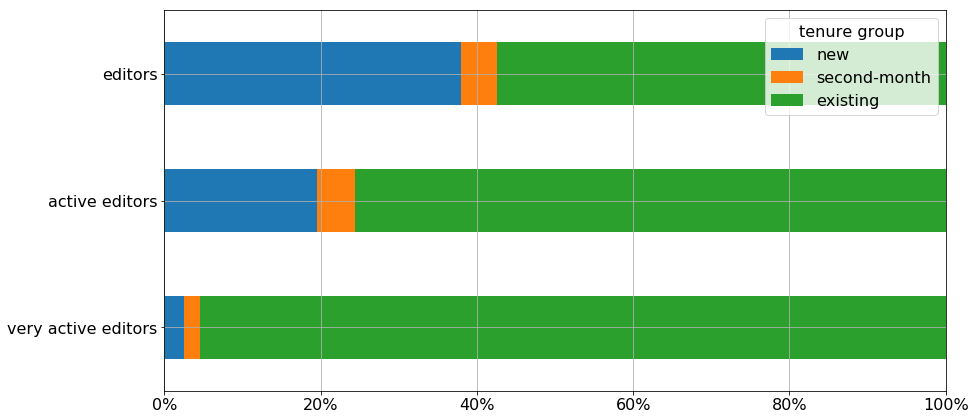

In [12]:
ax = (
    global_eds[-12:]
    .mean()
    .unstack()
    .reindex(["new", "second-month", "existing"], axis=1)
    .reindex(["very_active_eds", "active_eds", "eds"])
    .apply(lambda row: row / row.sum(), axis=1)
    .rename(index={
        "eds": "editors",
        "active_eds": "active editors",
        "very_active_eds": "very active editors"
    })
    .plot.barh(stacked=True)
)

ax.xaxis.set_major_formatter(pct_fmt)
plt.legend(title="tenure group");

# Overall trends in different activity groups

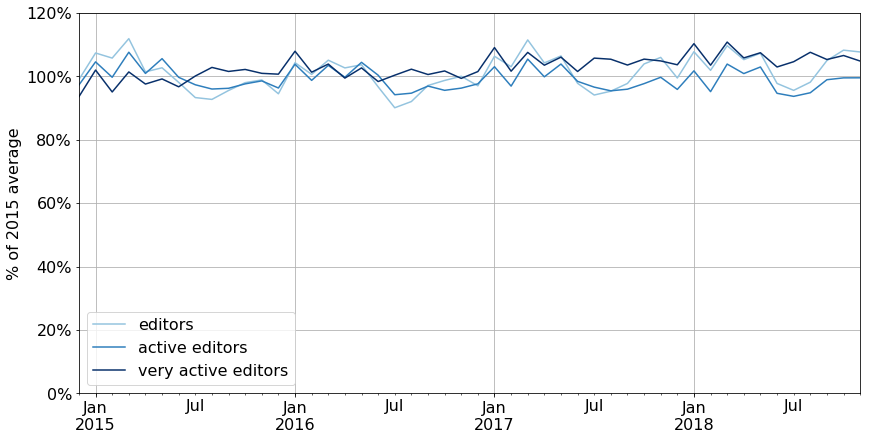

In [66]:
start_index = global_eds[1:13].mean()
indexed_global_eds = (global_eds / start_index).rename(columns={
    "eds": "editors",
    "active_eds": "active editors",
    "very_active_eds": "very active editors"
})

colors = plt.get_cmap("Blues")(np.linspace(0.4, 1, 3))
ax = indexed_global_eds.plot(ylim=(0, 1.2), color=colors)
plt.ylabel("% of 2015 average")
plt.xlabel("")
ax.yaxis.set_major_formatter(pct_fmt)

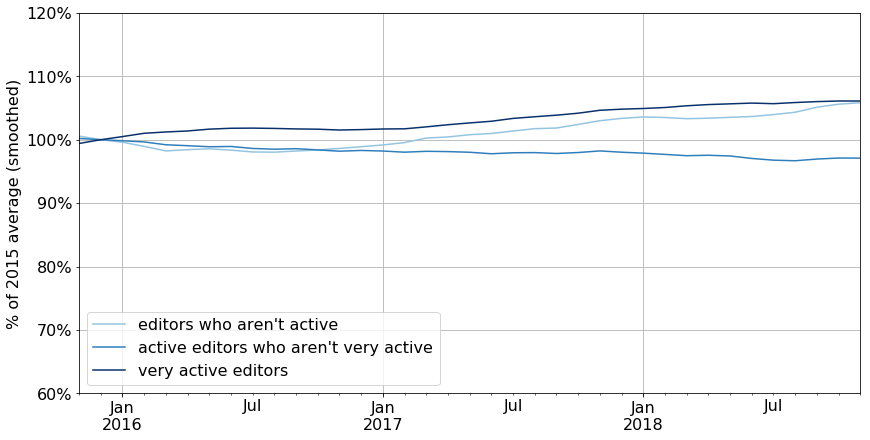

In [109]:
global_eds_unnested = (
global_eds
.assign(
    eds=lambda df: df["eds"] - df["active_eds"] - df["very_active_eds"],
    active_eds=lambda df: df["active_eds"] - df["very_active_eds"]
)
)

start_index = global_eds_unnested[1:13].mean()
ax = (global_eds_unnested / start_index).rolling(12).mean().rename(columns={
    "eds": "editors who aren't active",
    "active_eds": "active editors who aren't very active",
    "very_active_eds": "very active editors"
}).plot(ylim=(0.6, 1.2), color=colors)
plt.ylabel("% of 2015 average (smoothed)")
plt.xlabel("")
plt.legend(loc="lower left")
ax.yaxis.set_major_formatter(pct_fmt)

# Existing active editors

In [33]:
global_eds.tail()

eds                        active_eds                        \
age_group   existing       new second-month   existing      new second-month   
month                                                                          
2018-08-01  162140.0   99312.0      10754.0    61205.0  14004.0       3433.0   
2018-09-01  161549.0  117434.0      12143.0    60107.0  18274.0       3670.0   
2018-10-01  167421.0  117681.0      15120.0    61608.0  16679.0       4248.0   
2018-11-01  169136.0  114072.0      15442.0    62158.0  15662.0       4731.0   
2018-12-01   35840.0   20242.0       2899.0    13446.0   2539.0        766.0   

           very_active_eds                      
age_group         existing    new second-month  
month                                           
2018-08-01         12855.0  353.0        257.0  
2018-09-01         12479.0  418.0        283.0  
2018-10-01         12771.0  309.0        258.0  
2018-11-01         12582.0  281.0        256.0  
2018-12-01          3009.0   51.0         38.0

In [32]:
existing_active_eds = global_eds.loc[:, ("active_eds", "existing")]
eae_yoy = existing_active_eds / existing_active_eds.shift(12) - 1
print(pct_str(eae_yoy.tail(48).mean()))

0.2%


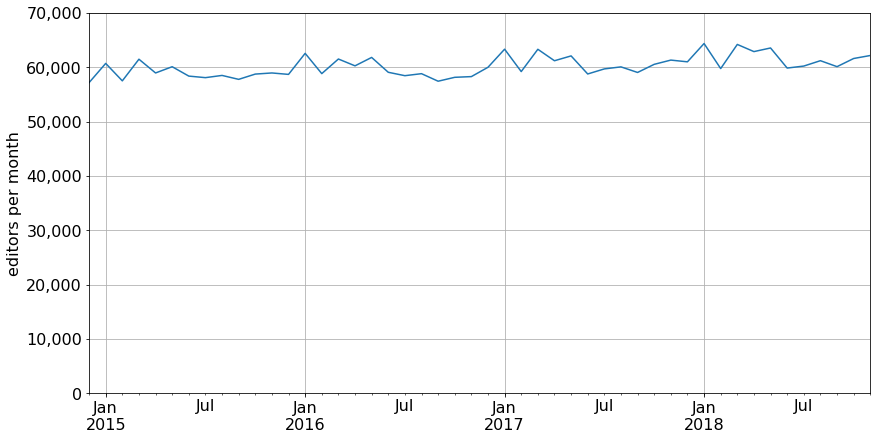

In [235]:
ax = global_eds.loc["2014-12-01":, ("active_eds", "existing")].plot(ylim=(0,70000))
plt.ylabel("editors per month")
plt.xlabel("")
ax.yaxis.set_major_formatter(comma_fmt);

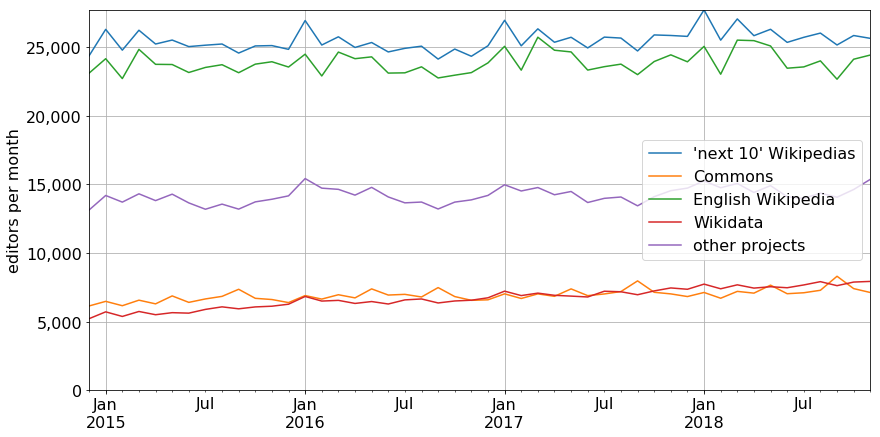

In [237]:
ax = (
    wiki_eds
    .xs(("active_eds", "existing"), axis=1, drop_level=True)
    .to_frame()
    .unstack("wiki")
    .stack([0, 1])
    .reset_index([1, 2], drop=True)
    .fillna(0)
    .groupby(wiki_segment, axis = 1).sum()
    .loc["2014-12-01":]
    .plot(ylim=0)
)

ax.yaxis.set_major_formatter(comma_fmt)
plt.xlabel("")
plt.ylabel("editors per month");

# New editors

In [26]:
new_eds = global_eds.loc[:, ("eds", "new")]
ne_yoy = new_eds / new_eds.shift(12) - 1
print(pct_str(ne_yoy.tail(48).mean()))

-3.2%


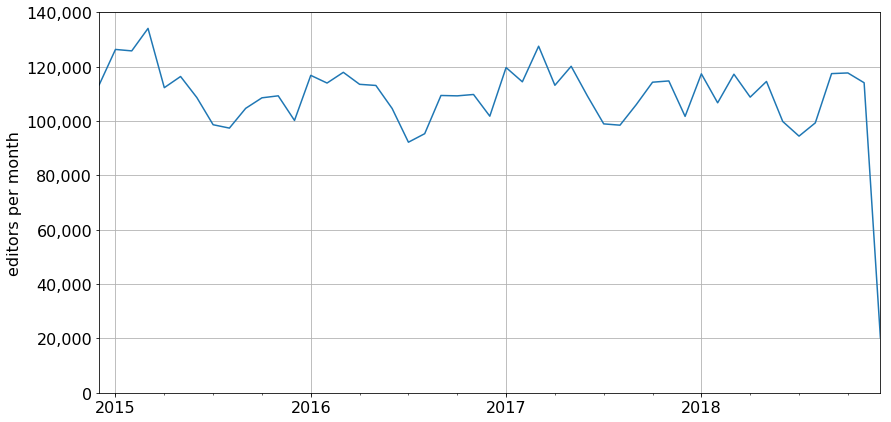

In [17]:
ax = global_eds.loc["2014-12-01":, ("eds", "new")].plot(ylim=(0, 140000))
plt.ylabel("editors per month")
plt.xlabel("")
ax.yaxis.set_major_formatter(comma_fmt);

# New active editors

In [28]:
new_active_eds = global_eds.loc[:, ("active_eds", "new")]
nae_yoy = new_active_eds / new_active_eds.shift(12) - 1
print(pct_str(nae_yoy.tail(48).mean()))

-6.7%


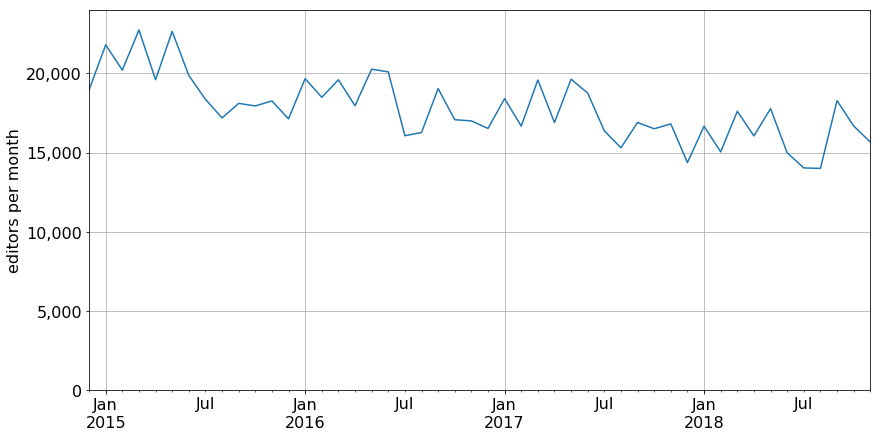

In [232]:
ax = global_eds.loc["2014-12-01":, ("active_eds", "new")].plot(ylim=(0, 24000))
plt.ylabel("editors per month")
plt.xlabel("")
ax.yaxis.set_major_formatter(comma_fmt);

# Very active editors

In [29]:
very_active_eds = global_eds.loc[:, ("very_active_eds")].sum(axis=1)
vae_yoy = very_active_eds / very_active_eds.shift(12) - 1
print(pct_str(vae_yoy.tail(48).mean()))

1.7%


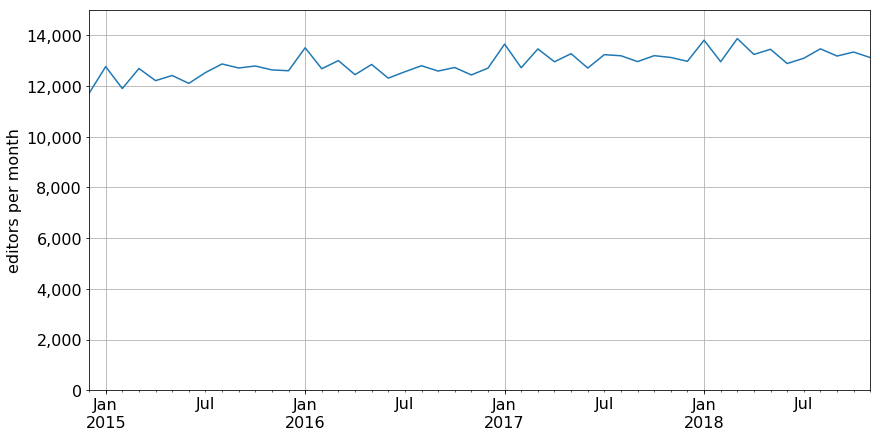

In [224]:
ax = global_eds.loc["2014-12-01":, "very_active_eds"].sum(axis=1).plot(ylim=(0, 15000))
plt.ylabel("editors per month")
plt.xlabel("")
ax.yaxis.set_major_formatter(comma_fmt);

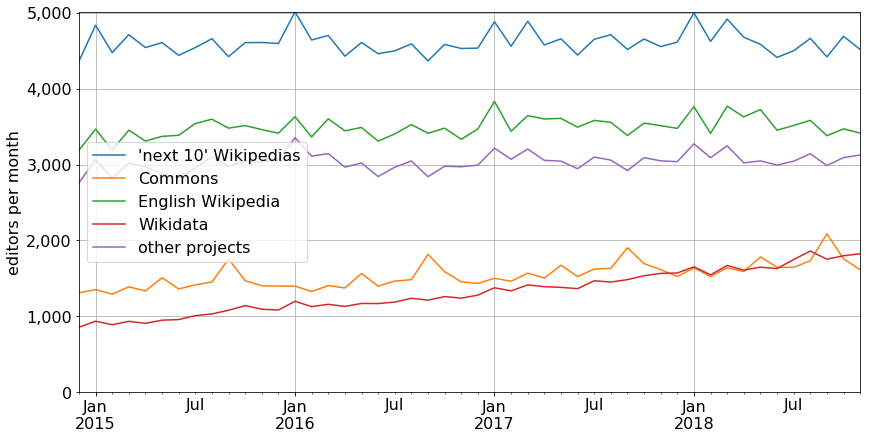

In [234]:
ax = (
    wiki_eds
    .xs(("very_active_eds"), axis=1, drop_level=True)
    .sum(axis=1)
    .unstack("wiki")
    .fillna(0)
    .groupby(wiki_segment, axis = 1).sum()
    .loc["2014-12-01":]
    .plot(ylim=0)
)

ax.yaxis.set_major_formatter(comma_fmt)
plt.xlabel("")
plt.ylabel("editors per month");